# Ambulance Dispatching Mathematical Modeling Formulation

## Mathematical Model

Let $CallType$ be the set of patient types $(h,i)$. Define the decision variable $y(s,j,(h,i))$ as the proportion of time the system is in state $s$ and selects action $j$ for customer type $(h,i)$. And lastly, $X(s,(h,i))$ denotes the set of available actions in state $s$ at time t given that a patient with priority $h$ arrives at location $i$. If a patient arrives, one of the available servers is dispatched to the patient, resulting in at most $m$ actions available in each state. The linear model can be written as follows:

--------------------------------------------------------------------------------------------------------


$
\max_y \sum_{s \in S, j \in X(s,(h,i)), (h,i) \in CallType} u_{ij}^h y(s,j,(h,i))
$

Subject to:


$
    \sum_{j' \in X(s',(h',i'))} y(s',j',(h',i')) -  
    \sum_{s \in S, j \in X(s,(h,i)), (h,i) \in CallType} p(s',(h',i') | s,j,(h,i)) y(s,j,(h,i)) = 0, 
    \quad \forall s' \in S, (h',i') \in CallType,
$

$
\sum_{s \in S, j \in X(s,(h,i)), (h,i) \in CallType} y(s,j,(h,i)) = 1,
$

$
y(s,j,(h,i)) \geq 0, \quad \forall s \in S, (h,i) \in CallType, j \in X(s,(h,i))
$

## Inbound and Outbound Flow Representation

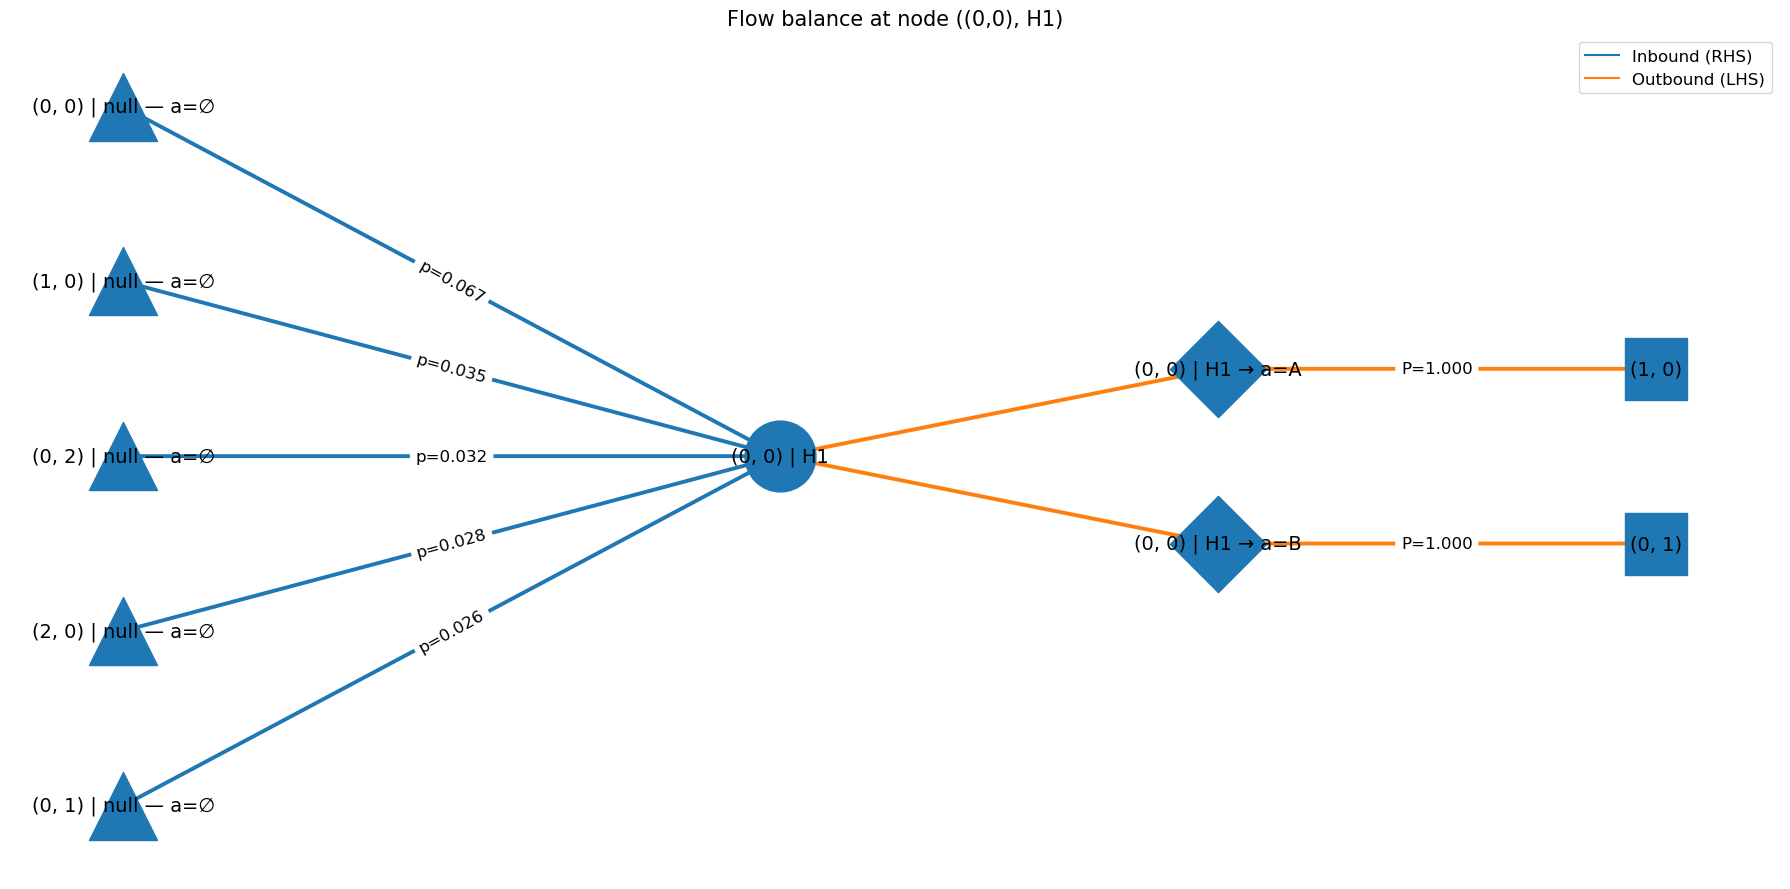

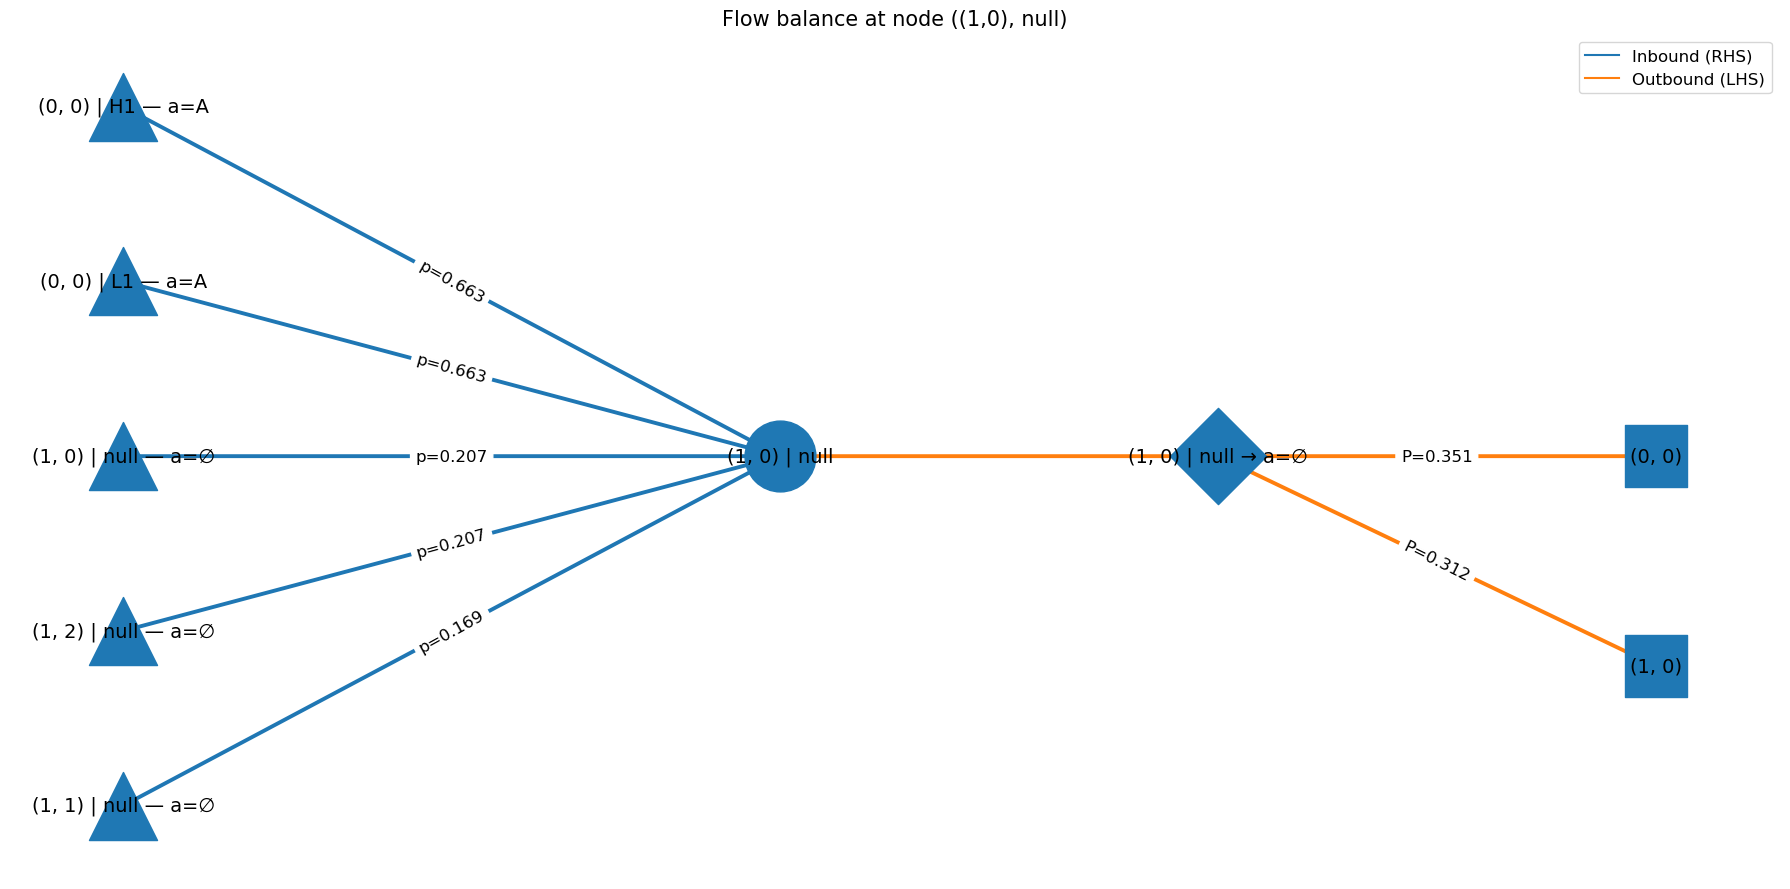

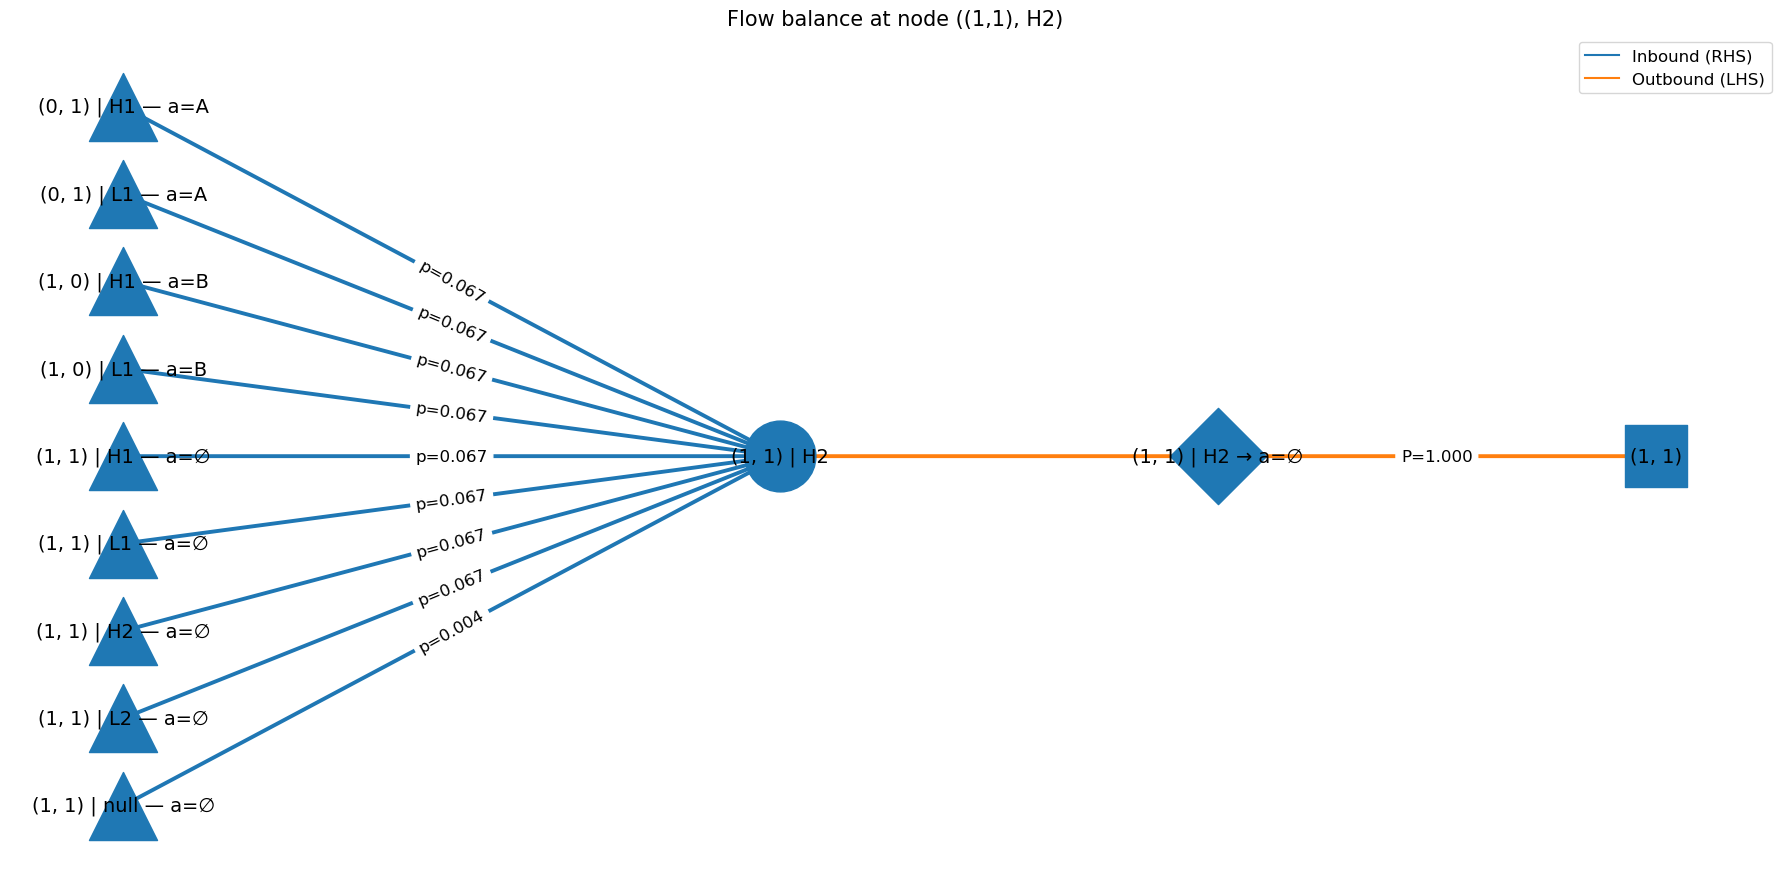

In [4]:
from flowVisualization import draw_inbound_outbound

draw_inbound_outbound((0,0), ("H",1), title="Flow balance at node ((0,0), H1)")
draw_inbound_outbound((1,0), "null",  title="Flow balance at node ((1,0), null)")
draw_inbound_outbound((1,1), ("H",2), title="Flow balance at node ((1,1), H2)")

## Implementation

In [1]:
import pandas as pd
import numpy as np

import gurobipy as gp
from gurobipy import GRB, Model, quicksum

from collections import defaultdict
from itertools import product # this is used to generate all possible states

    # S --> iterable of states
    # CallType --> iterable of (h, i) tuples
    # X --> dict: X[(s,(h,i))] -> iterable of actions j
    # u --> dict: u[(h,i,j)] -> reward u_ij^h (float)
    # P --> dict: P[((s,j,(h,i)), (s_prime,(h_prime,i_prime)))] -> prob

### States

In [2]:
def stateGenerator(n, m): # n: number of locations, m: number of ambulances
    states  = product(range(n + 1), repeat=m)
    return list(states)

### Call Types

In [3]:
def callTypeGenerator(n, priorityLevels):
    calltypes = product(range(n), range(priorityLevels))
    return list(calltypes)

### Actions

In [4]:
def actionGenerator(n, m):
    states = stateGenerator(n, m)
    calls = callTypeGenerator(n, 2)
    # dict: X[(s,(h,i))] -> iterable of actions j
    X = {}
    for s in states:
        for (i,h) in calls:
            key = (s, (i, h))
            X[key] = []
            for j in range(m):
                if s[j] == 0:
                    X[key].append(j)
    return X

in order to test the generator functions 

In [5]:
if True:  # Change to True to test the generator functions
    XX = actionGenerator(6, 2)  # Example for 6 locations and 2 ambulances
    for s in stateGenerator(6, 2):  # Example for 6 locations and 2 ambulances
        for ct in callTypeGenerator(6, 2):  # Example for 6 locations and 2 priority levels
            key = (s, ct)
            for j in XX.get(key, []):
                varname = f"y[{s},{j},{ct}]"
                print(varname)

y[(0, 0),0,(0, 0)]
y[(0, 0),1,(0, 0)]
y[(0, 0),0,(0, 1)]
y[(0, 0),1,(0, 1)]
y[(0, 0),0,(1, 0)]
y[(0, 0),1,(1, 0)]
y[(0, 0),0,(1, 1)]
y[(0, 0),1,(1, 1)]
y[(0, 0),0,(2, 0)]
y[(0, 0),1,(2, 0)]
y[(0, 0),0,(2, 1)]
y[(0, 0),1,(2, 1)]
y[(0, 0),0,(3, 0)]
y[(0, 0),1,(3, 0)]
y[(0, 0),0,(3, 1)]
y[(0, 0),1,(3, 1)]
y[(0, 0),0,(4, 0)]
y[(0, 0),1,(4, 0)]
y[(0, 0),0,(4, 1)]
y[(0, 0),1,(4, 1)]
y[(0, 0),0,(5, 0)]
y[(0, 0),1,(5, 0)]
y[(0, 0),0,(5, 1)]
y[(0, 0),1,(5, 1)]
y[(0, 1),0,(0, 0)]
y[(0, 1),0,(0, 1)]
y[(0, 1),0,(1, 0)]
y[(0, 1),0,(1, 1)]
y[(0, 1),0,(2, 0)]
y[(0, 1),0,(2, 1)]
y[(0, 1),0,(3, 0)]
y[(0, 1),0,(3, 1)]
y[(0, 1),0,(4, 0)]
y[(0, 1),0,(4, 1)]
y[(0, 1),0,(5, 0)]
y[(0, 1),0,(5, 1)]
y[(0, 2),0,(0, 0)]
y[(0, 2),0,(0, 1)]
y[(0, 2),0,(1, 0)]
y[(0, 2),0,(1, 1)]
y[(0, 2),0,(2, 0)]
y[(0, 2),0,(2, 1)]
y[(0, 2),0,(3, 0)]
y[(0, 2),0,(3, 1)]
y[(0, 2),0,(4, 0)]
y[(0, 2),0,(4, 1)]
y[(0, 2),0,(5, 0)]
y[(0, 2),0,(5, 1)]
y[(0, 3),0,(0, 0)]
y[(0, 3),0,(0, 1)]
y[(0, 3),0,(1, 0)]
y[(0, 3),0,(1, 1)]
y[(0, 3),0,(

### Rewards

In [ ]:
# u = { (h,i,j): u_hij, ... }
def rewardGenerator(n,m):
    u = {}
    for s in stateGenerator(n, m): 
        for ct in callTypeGenerator(n, m):  # Example for 6 locations and 2 priority levels
            key = (s, ct)
            for j in actionGenerator(n,m).get(key, []):
                i = ct[0]  # i is the first element of the call type tuple
                h = ct[1]  # h is the second element of the call type tuple
                u[(i, h, j)] = 1.0
                #print("i: ",i, "h: ",h, "j: ", j, "u: ", u[(i,h,j)])
    return u

### Transition Probabilities

In [ ]:
# 3) Transition probs (uniformized)
# Map ((s,j,(h,i)), (s_prime,(h_prime,i_prime))) -> p
P = { ((s,j,(h,i)), (s2,(h2,i2))) : prob, ... }

In [ ]:
def build_mdp_lp(S, CallType, X, u, P):
    m = Model("MDP_OccupancyLP")
    m.Params.OutputFlag = 0  # quiet by default; set to 1 for logs

    # Decision variables y[s,j,(i,h)] >= 0 only for feasible (s,(i,h),j)
    y = {}
    for s in S:
        for ct in CallType:
            key = (s, ct)
            for j in X.get(key, []):
                varname = f"y[{s},{j},{ct}]"
                y[(s, j, ct)] = m.addVar(lb=0.0, name=varname)
    m.update()

    # Objective: sum u_ij^h * y
    m.setObjective(quicksum(u.get((ct[0], ct[1], j), 0.0) * y[(s, j, ct)] for (s, j, ct) in y.keys()), GRB.MAXIMIZE)

    inbound = defaultdict(list)  # (s_prime, ct_prime) -> list of ((s,j,ct), prob)
    for ((s, j, ct), (sp, ctp)) , prob in P.items():
        if prob != 0.0:
            inbound[(sp, ctp)].append(((s, j, ct), prob))

    for sp in S:
        for ctp in CallType:
            lhs = quicksum(y[(sp, jp, ctp)] for jp in X.get((sp, ctp), []))
            rhs = quicksum(prob * y[(s, j, ct)] for ((s, j, ct), prob) in inbound.get((sp, ctp), []))
            m.addConstr(lhs - rhs == 0.0, name=f"flow[{sp},{ctp}]")

    # Normalization: sum y = 1
    m.addConstr(quicksum(y[v] for v in y) == 1.0, name="normalization")

    m.update()
    return m, y

In [9]:
def extract_policy(y_vars, X):
    """
    Given optimized y and the action sets X, compute a stationary randomized policy:
      q(s,(h,i))[j] = y(s,j,(h,i)) / sum_{j' in X(s,(h,i))} y(s,j',(h,i))
    Returns dict: policy[(s,(h,i))] -> dict {j: prob}
    """
    # Sum per (s,ct)
    denom = defaultdict(float)
    for (s, j, ct), var in y_vars.items():
        denom[(s, ct)] += var.X

    policy = {}
    for (s, ct), total in denom.items():
        choices = X.get((s, ct), [])
        pi = {}
        if total > 0:
            for j in choices:
                y_key = (s, j, ct)
                if y_key in y_vars:
                    pi[j] = y_vars[y_key].X / total
        else:
            # unreachable (s,ct): put zero probs
            for j in choices:
                pi[j] = 0.0
        policy[(s, ct)] = pi
    return policy

In [ ]:
model, y = build_mdp_lp(S, CallType, X, u, P)
model.optimize()

In [ ]:
pi = extract_policy(y, X)